# Explaining AutoGluon-Tabular Predictions with KernSHAP for Regression

This example uses a small diabetes dataset where the goal is to predict a continuous target variable (i.e. a regression problem). We train an AutoGluon regressor and then explain each of its predictions via [Shapely values](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) that quantify how much each feature contributed to a particular AutoGluon-prediction deviating from some "baseline" value. We use the [Kernel SHAP variant](https://shap.readthedocs.io/en/latest/generated/shap.KernelExplainer.html) which is appropriate for explaining arbitrary black-box models like the potentially heterogeneous ensemble of many models that AutoGluon-Tabular uses to make its predictions.

You must first install the [SHAP package](https://github.com/slundberg/shap/) (`pip install shap`).

**References:**  This notebook is derived from a [similar notebook](https://shap.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Diabetes%20regression.html) that demonstrates how to use Kernel SHAP with sklearn regression models. For more Kernel SHAP examples, you may refer to [this article](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a). Note that this notebook only demonstrates data that have been preprocessed to only contain numerical features; handling of categorical features is demonstrated in the notebook: "SHAP with AutoGluon-Tabular", which we recommend trying out first.

In [1]:
import time

import numpy as np
import pandas as pd
import shap
import sklearn

from autogluon.tabular import TabularPredictor

shap.initjs()

import warnings

warnings.filterwarnings("ignore")

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.


## Load the diabetes data

In [2]:
X, y = shap.datasets.diabetes()
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)


def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_valid) - y_valid) ** 2))))
    time.sleep(0.5)  # to let the print get out before any progress bars

## Train AutoGluon regressor

Here we just train directly on the raw data, without any normalizations. We first format the data in a manner suitable for AutoGluon training (pandas DataFrame):

In [3]:
label = "label"
feature_names = X_train.columns
train_data = X_train.copy()
train_data[label] = y_train
val_data = X_valid.copy()

display(train_data.head())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,label
74,0.012648,0.050680,0.002417,0.056301,0.027326,0.017162,0.041277,-0.039493,0.003712,0.073480,85.0
26,-0.107226,-0.044642,-0.077342,-0.026328,-0.089630,-0.096198,0.026550,-0.076395,-0.042572,-0.005220,137.0
45,0.027178,0.050680,-0.035307,0.032201,-0.011201,0.001504,-0.010266,-0.002592,-0.014956,-0.050783,53.0
389,-0.005515,0.050680,0.001339,-0.084857,-0.011201,-0.016658,0.048640,-0.039493,-0.041180,-0.088062,51.0
154,0.067136,0.050680,0.020739,-0.005671,0.020446,0.026243,-0.002903,-0.002592,0.008640,0.003064,197.0


We then train an AutoGluon classifier:

In [4]:
predictor = TabularPredictor(label=label, problem_type="regression").fit(train_data, time_limit=20)

No path specified. Models will be saved in: AutogluonModels/ag-20201021_071251/
Beginning AutoGluon training ... Time limit = 20s
AutoGluon will save models to AutogluonModels/ag-20201021_071251/
AutoGluon Version:  0.0.15b20201020
Train Data Rows:    353
Train Data Columns: 10
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5113.28 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 10 | ['age', 'sex', 'bmi', '

## Explain predictions

SHAP is intended to explain how much each feature contributes to a particular prediction. In this regression context, this corresponds to how much a predicted value differs from a baseline reference value. We first create a wrapper class around AutoGluon to allow it to be called for prediction inside of the `shap` package:

In [5]:
class AutogluonWrapper:
    def __init__(self, predictor, feature_names):
        self.ag_model = predictor
        self.feature_names = feature_names

    def predict(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1, -1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict(X)

Next, we define the baseline reference value of the features (AutoGluon predictions will be interpreted in terms of their difference from the prediction for the baseline feature-values). Rather than use the whole training set to estimate average column-values as our reference, we summarize with a set of weighted kmeans, each weighted by the number of points they represent.

In [6]:
X_train_summary = shap.kmeans(X_train, 10)
print("Baseline feature-values: \n", X_train_summary)

Baseline feature-values: 


We can now create a `KernelExplainer` which will return Kernel SHAP values to explain particular AutoGluon predictions.

In [7]:
ag_wrapper = AutogluonWrapper(predictor, feature_names)
print_accuracy(ag_wrapper.predict)

explainer = shap.KernelExplainer(ag_wrapper.predict, X_train_summary)

NSHAP_SAMPLES = 100  # how many samples to use to approximate each Shapely value, larger values will be slower
N_VAL = (
    30  # how many datapoints from validation data should we interpret predictions for, larger values will be slower
)

Root mean squared test error = 58.16574872551215


Let's first explain a prediction for a single datapoint from the training data.

In [8]:
ROW_INDEX = 0  # index of an example datapoint
single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict(single_datapoint)

shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[ROW_INDEX, :])

num_full_subsets = 1
remaining_weight_vector = [0.32588454 0.24829299 0.21725636 0.20856611]
num_paired_subset_sizes = 4
weight_left = 0.6072380418010941
np.sum(w_aug) = 9.999999999999998
np.sum(self.kernelWeights) = 0.9999999999999997
phi = [-2.16673763 -7.30257651 -6.01534141 17.9040135  -0.69770945  2.19206997
 -4.45803757 -8.42249673  5.32206295 12.13680085]


We can also plot Kernel SHAP explanations aggregated across many predictions, say over the first `N_VAL` datapoints of the validation data. 

In [9]:
shap_values = explainer.shap_values(X_valid.iloc[0:N_VAL, :], nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value, shap_values, X_valid.iloc[0:N_VAL, :])

num_full_subsets = 1
remaining_weight_vector = [0.32588454 0.24829299 0.21725636 0.20856611]
num_paired_subset_sizes = 4
weight_left = 0.6072380418010941
np.sum(w_aug) = 10.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.          0.         63.69359417 27.21267897  5.20834155  0.
  0.81633909  0.         10.26999198  6.50870779]
num_full_subsets = 1
remaining_weight_vector = [0.32588454 0.24829299 0.21725636 0.20856611]
num_paired_subset_sizes = 4
weight_left = 0.6072380418010941
np.sum(w_aug) = 10.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.          0.         29.25021484 15.93078397  0.          3.27738944
  0.          1.91848041 38.04089951  0.        ]
num_full_subsets = 1
remaining_weight_vector = [0.32588454 0.24829299 0.21725636 0.20856611]
num_paired_subset_sizes = 4
weight_left = 0.6072380418010941
np.sum(w_aug) = 9.999999999999998
np.sum(self.kernelWeights) = 0.9999999999999996
phi = [ 14.31946816  -7.39413279   4.36798833   9.06797456   6.19110434
  -6.47101103   7.10822616

remaining_weight_vector = [0.32588454 0.24829299 0.21725636 0.20856611]
num_paired_subset_sizes = 4
weight_left = 0.6072380418010941
np.sum(w_aug) = 10.0
np.sum(self.kernelWeights) = 1.0
phi = [  0.           0.          28.40184855 -18.76787593   4.58736196
  10.40780163   0.          -6.89448539 -39.76472483  -2.61805289]
num_full_subsets = 1
remaining_weight_vector = [0.32588454 0.24829299 0.21725636 0.20856611]
num_paired_subset_sizes = 4
weight_left = 0.6072380418010941
np.sum(w_aug) = 10.0
np.sum(self.kernelWeights) = 0.9999999999999997
phi = [  0.          -5.97731577  30.36177332 -17.87193754 -10.1351185
   0.           5.51059166  18.40536102  33.5459797    5.10274154]
num_full_subsets = 1
remaining_weight_vector = [0.32588454 0.24829299 0.21725636 0.20856611]
num_paired_subset_sizes = 4
weight_left = 0.6072380418010941
np.sum(w_aug) = 10.0
np.sum(self.kernelWeights) = 1.0000000000000002
phi = [  0.           9.83915705  12.30750499  -8.15644688 -19.68456459
   3.88742185   0.

A summary plot is an even better way to see the relative impact of all features over many datapoints. Features are sorted by the sum of their SHAP value magnitudes across all samples.

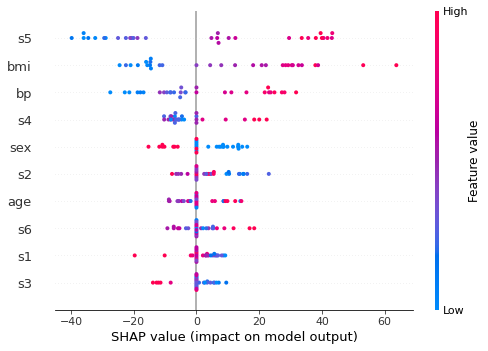

In [10]:
shap.summary_plot(shap_values, X_valid.iloc[0:N_VAL, :])

A dependence plot can be used to visualize how the BMI influences predicted outcomes.

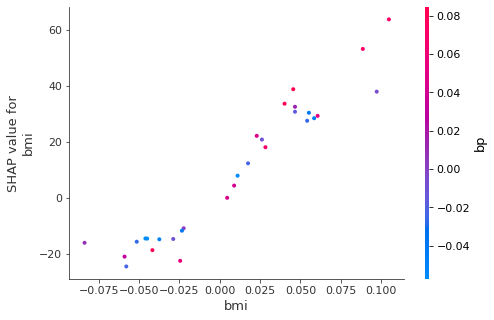

In [11]:
shap.dependence_plot("bmi", shap_values, X_valid.iloc[0:N_VAL, :])

## Scoring Overall Feature Importance via Permutation Shuffling

Note that if you'd like to understand how much each feature contributes to AutoGluon's general predictive accuracy (rather than explaining individual predictions), AutoGluon offers a built-in method for this based on [permutation-shuffling](https://explained.ai/rf-importance/):

In [12]:
val_data[label] = y_valid  # add labels to validation DataFrame
predictor.feature_importance(val_data)

Computing raw permutation importance for 10 features on weighted_ensemble_k0_l1 ...
	1.76s	= Expected runtime
	1.54s	= Actual runtime


s5     11.321709
bmi     4.601622
age     1.945009
s4      0.802883
s3      0.736253
sex     0.549610
s6     -0.172562
s1     -0.242301
bp     -0.295671
s2     -0.673330
dtype: float64

Features with near zero or negative importance score above hardly contribute at all to AutoGluon's overall accuracy on the validation data, whereas features near the top of this list contain the most predictive signal.